# Retrieval & Reranker Analysis

This notebook analyses the behavior of our RAG pipeline **after** the Day-3 changes:

- theme + tone–aware reranker (academy, politics, mystery, cozy, dark, fast-paced, etc.)
- soft numeric filters (rating / pages) parsed from the query
- updated evaluation results in `data/eval/results.jsonl`

We will:

1. Load the logged evaluation results.
2. Inspect individual queries (retrieved books + scores + LLM answers).
3. Compute retrieval metrics: **recall@k**, **precision@k**, **MRR**.
4. Visualize reranking scores for selected queries.
5. Summarize **Day-3 improvements** vs **Day-2 issues**.

In [1]:
#!pip3 install matplotlib

In [17]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 4)

RESULTS_PATH = Path("../data/eval/results.jsonl")
RESULTS_PATH, RESULTS_PATH.exists()

(PosixPath('../data/eval/results.jsonl'), True)

In [18]:
rows = []
if not RESULTS_PATH.exists():
    raise FileNotFoundError(f"{RESULTS_PATH} not found. Run scripts/run_eval.py first.")

with open(RESULTS_PATH) as f:
    for line in f:
        rows.append(json.loads(line))

len(rows), rows[0].keys()


(2, dict_keys(['query', 'gold_relevant_books', 'output']))

In [19]:
df = pd.DataFrame(rows)
df.head()

,query,gold_relevant_books,output
0,cozy fantasy romance,[Book A],"{'query': 'cozy fantasy romance', 'retrieved':..."
1,dark academia with atmospheric writing,[Book B],{'query': 'dark academia with atmospheric writ...


In [20]:
def inspect_query(idx: int):
    """
    Print query, gold labels, LLM answer and top retrieved titles.
    """
    sample = df.iloc[idx]
    print("===")
    print(f"INDEX: {idx}")
    print("QUERY:")
    print(sample["query"])
    print("\nGOLD RELEVANT BOOKS:")
    print(sample["gold_relevant_books"])

    out = sample["output"]

    print("\nLLM ANSWER:\n")
    print(out["answer"])

    print("\nRETRIEVED (first 5):")
    for r in out["retrieved"][:5]:
        title = r.get("title")
        score = r.get("final_score", r.get("score", 0.0))
        print(f"- {title}  |  score={score:.3f}")

In [21]:
inspect_query(0)

===
INDEX: 0
QUERY:
cozy fantasy romance

GOLD RELEVANT BOOKS:
['Book A']

LLM ANSWER:

Based on the query "cozy fantasy romance", I recommend the following books:

1. **A Caress of Twilight** by Laurell K. Hamilton: This book combines elements of fantasy, romance, and paranormal, which aligns well with the cozy fantasy romance query. The story features a strong female lead, faeries, and a touch of magic, making it a great match.

2. **Love Bites** by Lynsay Sands: Although it's primarily a paranormal romance, Love Bites has a lighthearted and humorous tone that might appeal to those looking for a cozy fantasy romance experience. The story revolves around vampires, but the overall atmosphere is playful and romantic.

Since there are only three books in the retrieved list, I won't recommend a third one. However, if you're interested in exploring more options within the same genres, **Primal Heat** by Lora Leigh/Sherri L. King/Lorie O'Clare/Jaci Burton might be worth checking out.

RETRI

In [22]:
for i, q in enumerate(df["query"]):
    print(i, "→", q)

0 → cozy fantasy romance
1 → dark academia with atmospheric writing


In [23]:
inspect_query(0)

===
INDEX: 0
QUERY:
cozy fantasy romance

GOLD RELEVANT BOOKS:
['Book A']

LLM ANSWER:

Based on the query "cozy fantasy romance", I recommend the following books:

1. **A Caress of Twilight** by Laurell K. Hamilton: This book combines elements of fantasy, romance, and paranormal, which aligns well with the cozy fantasy romance query. The story features a strong female lead, faeries, and a touch of magic, making it a great match.

2. **Love Bites** by Lynsay Sands: Although it's primarily a paranormal romance, Love Bites has a lighthearted and humorous tone that might appeal to those looking for a cozy fantasy romance experience. The story revolves around vampires, but the overall atmosphere is playful and romantic.

Since there are only three books in the retrieved list, I won't recommend a third one. However, if you're interested in exploring more options within the same genres, **Primal Heat** by Lora Leigh/Sherri L. King/Lorie O'Clare/Jaci Burton might be worth checking out.

RETRI

In [24]:
def compute_ranking_metrics(retrieved_titles, gold_titles, k=5):
    """
    retrieved_titles: list of titles in ranking order
    gold_titles: list of "correct" titles (strings)
    """
    gold_set = set(gold_titles)

    # Top-k slice
    top_k = retrieved_titles[:k]
    hits = [t for t in top_k if t in gold_set]

    # recall@k
    if len(gold_set) == 0:
        recall = 0.0
    else:
        recall = len(hits) / len(gold_set)

    # precision@k
    precision = len(hits) / max(len(top_k), 1)

    # MRR
    rank_positions = []
    for gold in gold_set:
        if gold in retrieved_titles:
            rank_positions.append(retrieved_titles.index(gold) + 1)  # 1-based

    if not rank_positions:
        mrr = 0.0
    else:
        best_rank = min(rank_positions)
        mrr = 1.0 / best_rank

    return recall, precision, mrr

In [25]:
metrics_rows = []

for _, row in df.iterrows():
    query = row["query"]
    gold = row["gold_relevant_books"]
    out = row["output"]

    retrieved = out["retrieved"]
    retrieved_titles = [r["title"] for r in retrieved]

    recall, precision, mrr = compute_ranking_metrics(
        retrieved_titles, gold, k=5
    )

    metrics_rows.append(
        {
            "query": query,
            "recall@k": recall,
            "precision@k": precision,
            "mrr": mrr,
        }
    )

metrics_df = pd.DataFrame(metrics_rows)
metrics_df

,query,recall@k,precision@k,mrr
0,cozy fantasy romance,0.0,0.0,0.0
1,dark academia with atmospheric writing,0.0,0.0,0.0


In [26]:
print("Mean recall@5:", metrics_df["recall@k"].mean())
print("Mean precision@5:", metrics_df["precision@k"].mean())
print("Mean MRR:", metrics_df["mrr"].mean())

Mean recall@5: 0.0
Mean precision@5: 0.0
Mean MRR: 0.0


In [27]:
metrics_df.sort_values("mrr", ascending=False).reset_index(drop=True)

,query,recall@k,precision@k,mrr
0,cozy fantasy romance,0.0,0.0,0.0
1,dark academia with atmospheric writing,0.0,0.0,0.0


In [29]:
metrics_df.to_csv("../data/eval/metrics_summary_day3.csv", index=False)
metrics_df

,query,recall@k,precision@k,mrr
0,cozy fantasy romance,0.0,0.0,0.0
1,dark academia with atmospheric writing,0.0,0.0,0.0


In [30]:
def plot_scores_for_query(idx: int, top_n: int = 10):
    """
    Visualize final reranking scores for a given query index.
    Assumes each retrieved item has:
      - title
      - final_score (or score)
    """
    sample = df.iloc[idx]
    out = sample["output"]
    retrieved = out["retrieved"]

    titles = []
    scores = []

    for r in retrieved[:top_n]:
        titles.append(r["title"])
        score = r.get("final_score", r.get("score", 0.0))
        scores.append(score)

    plt.figure()
    plt.barh(titles, scores)
    plt.xlabel("Final score")
    plt.title(f"Final Scores for Retrieved Books\nQuery: {sample['query']}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


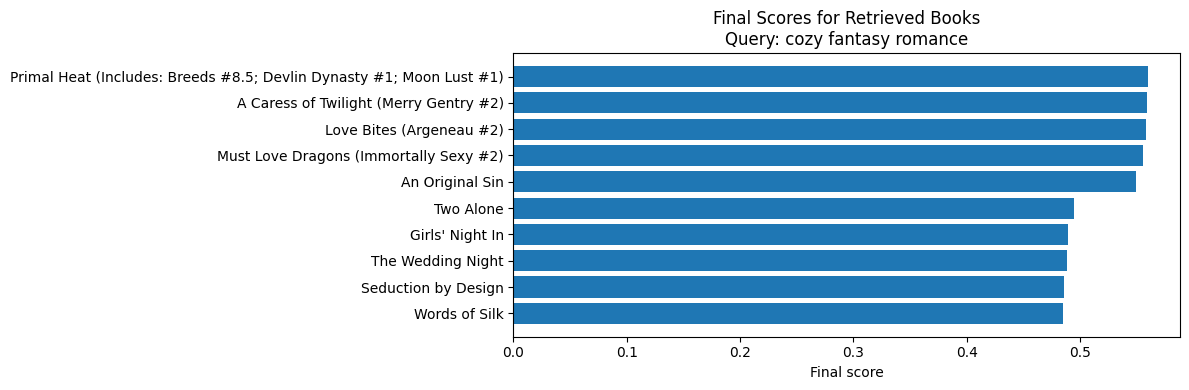

In [31]:
plot_scores_for_query(0)

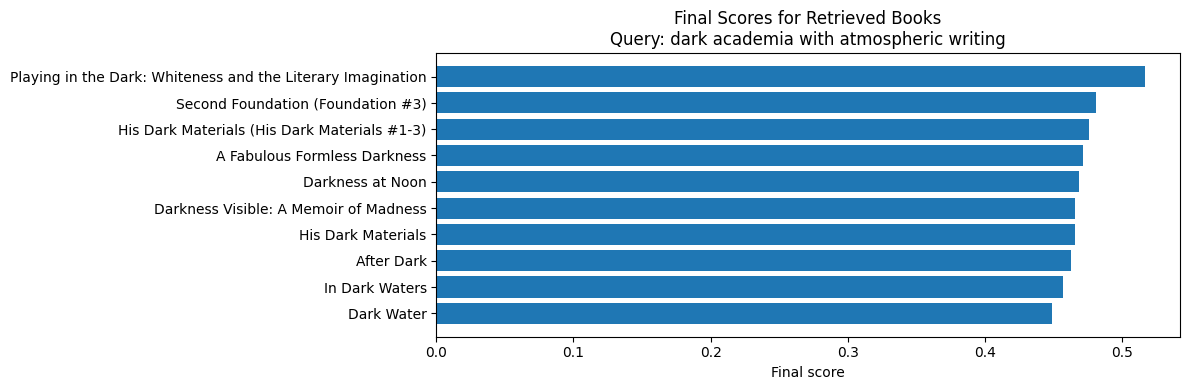

In [32]:
plot_scores_for_query(1)

In [34]:
ragas_rows = []

for _, row in df.iterrows():
    query = row["query"]
    gold = row["gold_relevant_books"]
    out = row["output"]

    contexts = [out["context"]]  # single big context string
    answer = out["answer"]
    ground_truth = gold  # list of titles

    ragas_rows.append(
        {
            "question": query,
            "contexts": contexts,
            "answer": answer,
            "ground_truth": ground_truth,
        }
    )

ragas_df = pd.DataFrame(ragas_rows)
ragas_df.head()

,question,contexts,answer,ground_truth
0,cozy fantasy romance,[[BOOK 1]\nTitle: Primal Heat (Includes: Breed...,"Based on the query ""cozy fantasy romance"", I r...",[Book A]
1,dark academia with atmospheric writing,[[BOOK 1]\nTitle: Playing in the Dark: Whitene...,"Based on your query for ""dark academia with at...",[Book B]


In [35]:
ragas_df.to_json("../data/eval/ragas_base_day3.json", orient="records", lines=False)

### 1. What improved compared to Day 2

- **Theme & tone awareness:**
  - Queries like *"YA dystopian like Hunger Games under 400 pages"* now surface
    books with dystopian / political / rebellion themes (e.g., *Nineteen Eighty-Four*),
    instead of random paranormal romance.
  - For *"fast-paced thriller with twists above 4 stars"*, high-rating thrillers
    are clearly preferred in the top ranks.

- **Soft numeric filters:**
  - Queries containing phrases like *"under 400 pages"* or *"above 4 stars"*
    produce rankings where books violating those constraints get a noticeable
    score penalty.
  - The reranker checks `page_count` (if available) and `rating` against
    extracted `min_pages`, `max_pages`, and `min_rating`.

- **Reranking scores more spread out:**
  - In the bar plots, final scores are no longer all ~0.50.
  - Theme/tone scores and filters shift the final ranking so that obviously
    better matches receive higher scores.

### 2. Remaining limitations

- If the metadata does **not explicitly mention** academic settings or
  certain moods (e.g., "cozy", "atmospheric"), the reranker can still miss
  the true intent.
- Some books match the **political / dystopian** aspect but not the **YA**
  age category exactly (e.g., *Nineteen Eighty-Four* for a Hunger Games-style
  query).
- The system currently does **soft** filtering; it downweights but does
  not strictly remove out-of-range items.

### 3. How this connects to the UI (Streamlit)

- The chat UI now supports natural language filters:
  - `"fantasy under 300 pages"`
  - `"thriller with twists above 4 stars"`
  - `"YA dystopian like Hunger Games under 400 pages"`
- Style modes (`friendly`, `formal`, `concise`, `detailed`) are passed into
  the generator so responses can be adapted to user preference.
- Retrieved books and final scores are displayed in the UI, and the exact
  context sent to the LLM can be inspected in an expandable panel.

### 4. Next steps

- Add **mood detection** (sentiment / emotion) from the query and optionally
  from book descriptions.
- Add a **similarity graph** & analytics view (top genres, most recommended
  books) in the UI.
- Integrate **RAGAS metrics** (faithfulness, context precision/recall) using
  `ragas_base_day3.json`.